In [34]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

from nltk.stem import PorterStemmer

In [3]:
train_data = pd.read_csv('../data/train.csv', header=None)
train_data.columns=['polarity', 'title', 'text',]

val_data = pd.read_csv('../data/val.csv', header=None)
val_data.columns=['polarity', 'title', 'text',]

test_data = pd.read_csv('../data/test.csv')

In [9]:
# sets_combined_x = pd.concat([X_train_preproc, X_val_preproc], ignore_index=True)
sets_combined_y = pd.concat([y_train, y_val], ignore_index=True)

In [4]:
X_train   = train_data['text']
y_train   = train_data['polarity']

# get val data
X_val    = val_data['text']
y_val    = val_data['polarity']

# get test data
X_test   = test_data['text']
y_test   = test_data['polarity']

print(f"Train Data Shape: {X_train.shape[0]:,}")
print(f"Validation Data Shape: {X_val.shape[0]:,}")
print(f"Test Data Shape: {X_test.shape[0]:,}")

print(" ")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 1 in test dataset as percentage: {((y_test == 1).sum() / (X_test.shape[0])) * 100:0.2f}%")
print(f"Number of labels = 2 in test dataset as percentage: {((y_test == 2).sum() / (X_test.shape[0])) * 100:0.2f}%")

Train Data Shape: 3,600,000
Validation Data Shape: 400,000
Test Data Shape: 33,161
 
Number of labels = 1 in train dataset as percentage: 50.00%
Number of labels = 2 in train dataset as percentage: 50.00%
 
Number of labels = 1 in val dataset as percentage: 50.00%
Number of labels = 2 in val dataset as percentage: 50.00%
 
Number of labels = 1 in test dataset as percentage: 2.45%
Number of labels = 2 in test dataset as percentage: 97.55%


In [13]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

# tfidf = TfidfVectorizer(strip_accents='unicode', lowercase=True, tokenizer=tokenizer_porter, stop_words='english', max_df=0.9)
# X_train_tfidf = tfidf.fit_transform(sets_combined_x)
# print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")

# X_test_tfidf = tfidf.transform(X_test_preproc)
# print(f"\nTF-IDF feature matrix shape: {X_test_tfidf.shape}")

# pickle.dump(tfidf, open("./Vectorized Dataset/tfidf_vectorizer.pkl", "wb"))
# pickle.dump(X_train_tfidf, open("./Vectorized Dataset/X_train_tfidf.pkl", "wb"))
# pickle.dump(X_test_tfidf, open("./Vectorized Dataset/X_text_tfidf.pkl", "wb"))

In [15]:
with open('../data/NegSent/tfidf_vectorizer.pkl', 'rb') as file:
    tfidf = pickle.load(file)
with open('../data/NegSent/X_train_tfidf.pkl', 'rb') as file:
    X_train_tfidf = pickle.load(file)
with open('../data/NegSent/X_text_tfidf.pkl', 'rb') as file:
    X_text_tfidf = pickle.load(file)

C:\Users\utgoy\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\utgoy\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
model = LogisticRegression(**{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 1, 'random_state': 42})
model.fit(X_train_tfidf, sets_combined_y)

LogisticRegression(C=1, random_state=42, solver='liblinear')

In [24]:
y_pred = model.predict(X_text_tfidf)

val_accuracy_lr = accuracy_score(y_test, y_pred) # Calculate validation accuracy

print("\n--- Logistic Regression (Validation) ---")
print(f"Validation Accuracy: {val_accuracy_lr:.4f}")
print(f"Validation F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("Validation Classification Report:")
print(classification_report(y_test, y_pred))


--- Logistic Regression (Validation) ---
Validation Accuracy: 0.9056
Validation F1 Score: 0.9334
Validation Classification Report:
              precision    recall  f1-score   support

           1       0.18      0.81      0.30       812
           2       0.99      0.91      0.95     32349

    accuracy                           0.91     33161
   macro avg       0.59      0.86      0.62     33161
weighted avg       0.97      0.91      0.93     33161



In [26]:
# Extract feature names from the vectorizer
feature_names = tfidf.get_feature_names_out()

# Get coefficients from the logistic regression model
# Assuming model is a binary logistic regression with shape (1, n_features)
coefficients = model.coef_[0]

# Sort features by their coefficient values
# Negative coefficients are associated with negative class, positive with positive class
sorted_indices = np.argsort(coefficients)

# Adjust these numbers as needed (e.g., top 20)
top_negative_indices = sorted_indices[:20]  # 20 most negative words

# Get the corresponding words and their coefficients
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

# Print top negative words (aspects potentially causing negative feedback)
print("Top Negative Words:")
for word, coef in top_negative_words:
    print(f"{word}: {coef:.3f}")

Top Negative Words:
worst: -16.710
wast: -15.729
poorli: -14.071
disappoint: -13.704
uninspir: -11.841
useless: -11.652
poor: -11.504
worthless: -11.088
return: -11.061
horribl: -10.848
bore: -10.805
aw: -10.710
terribl: -10.700
mediocr: -10.046
uninterest: -9.994
forgett: -9.394
unfortun: -9.229
unaccept: -9.161
refund: -9.022
insult: -8.959


In [ ]:
word_to_coeff = dict(zip(feature_names, coefficients))
word_weights = {word: abs(coef_val) for word, coef_val in word_to_coeff.items() if coef_val < 0}

# 5. Generate the word cloud
wc = WordCloud(width=800, height=400, background_color="white")
wc.generate_from_frequencies(word_weights)

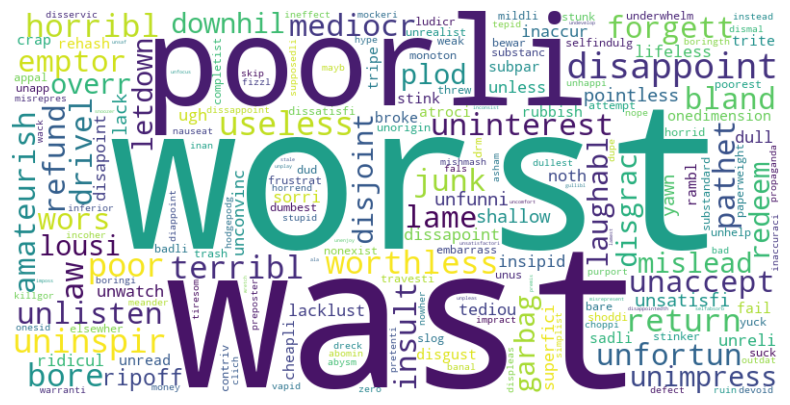

In [36]:
# 6. Display the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
# Step 2: Get Top Negative Words and Their Indices
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

# Precompute word indices for faster lookup
word_indices = {word: tfidf.get_feature_names_out().tolist().index(word) for word, _ in top_negative_words}

In [ ]:
# pickle.dump(word_indices, open("./Vectorized Dataset/word_indices.pkl", "wb"))

In [50]:
# Step 3: Efficiently Compute Contributions using Sparse Matrix Operations
# Initialize an array to store total negative contributions for each comment
total_contributions = np.zeros(X_text_tfidf.shape[0])

# For each top negative word, get its TF-IDF values and multiply by the coefficient
for word, coef in top_negative_words:
    if word in word_indices:  # Ensure the word exists in the vocabulary
        word_index = word_indices[word]

        # Extract the TF-IDF values for this word from the sparse matrix
        word_tfidf_values = X_text_tfidf[:, word_index].toarray().flatten()

        # Calculate the contribution of this word to each comment
        total_contributions += word_tfidf_values * coef

# Step 4: Rank Comments by Their Negative Contribution

# Add the contribution scores to the DataFrame for easier analysis
test_data['negative_contribution'] = total_contributions

# Sort by the negative contribution in descending order (most negative at the top)
top_negative_comments = test_data.sort_values(by='negative_contribution', ascending=True).copy()

# Step 5: Show the Top 10 Comments with the Most Negative Words
print("Top 10 Comments with the Most Negative Words:")
display(top_negative_comments[['polarity', 'text', 'negative_contribution']].head(10))

Top 10 Comments with the Most Negative Words:


,polarity,text,negative_contribution
3097,1,Waste of money,-11.727930
14710,1,Returned it. it was a poor reader and clearly ...,-10.413735
9235,1,Could not get this to work with my chromecast ...,-9.121640
8632,1,I returned the item was not what I expected ve...,-8.514270
32116,2,Product does not disappoint. It does what it s...,-8.508678
15187,1,"Not sure why, but it kept freezing and ended u...",-8.351564
22346,1,This product not good waste of money I would r...,-8.327716
24013,2,No disappointment for this Amazon Echo!Great p...,-7.933465
28573,2,My previous experience with Amazon stick was a...,-7.665054
14389,1,Worst product ever. Constantly screwing up and...,-7.296083


In [54]:
top_negative_comments.to_csv('../data/top_negative_commentsv1.csv', index=False)

In [ ]:
top_negative_words = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

# Prepare a list to hold the contribution scores for each comment
comment_contributions = []

# Loop through the test dataset and calculate the contribution of top negative words
for i, comment in enumerate(test_data['text']):
    # Get the TF-IDF scores for the current comment
    comment_tfidf = X_text_tfidf[i]

    # Calculate the total negative contribution of the comment (by summing contributions from top negative words)
    total_negative_contribution = 0
    for word, coef in top_negative_words:
        # Get the index of the word in the vectorizer's feature names
        if word in feature_names:
            word_index = feature_names.tolist().index(word)
            tfidf_score = comment_tfidf[0, word_index]

            # Contribution of this word to the sentiment (TF-IDF * Coefficient)
            contribution = tfidf_score * coef
            total_negative_contribution += contribution

    # Store the total negative contribution for this comment
    comment_contributions.append((i, total_negative_contribution))

# Sort the comments by their total negative contribution in descending order
# comment_contributions.sort(key=lambda x: x[1], reverse=True)

In [ ]:
test_data['negative_contribution_v2'] = comment_contributions

top_negative_comments = test_data.sort_values(by='negative_contribution_v2', ascending=True).copy()

# Step 5: Show the Top 10 Comments with the Most Negative Words
print("Top 10 Comments with the Most Negative Words:")
display(top_negative_comments[['polarity', 'text', 'negative_contribution_v2']].head(10))

In [ ]:
top_negative_comments.to_csv('../data/top_negative_commentsv2.csv', index=False)